## this code uses mne pipeline and estimator generalizer from MVPA package

#### import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)
from scipy.spatial.distance import squareform
import itertools
import os
%run EEG_auxiliary_module_sptm_wICA.ipynb
# from pdb import set_trace

#### read data and classify per subject

101 started


<ipython-input-1-1b7b8af1934a>:19: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  AllEpochs = eegData.copy().crop(times[0],times[1]).get_data()



101 done
102 started



102 done
103 started



103 done
104 started



104 done
105 started



105 done
106 started



106 done
107 started



107 done
108 started



108 done
109 started



109 done
110 started



110 done


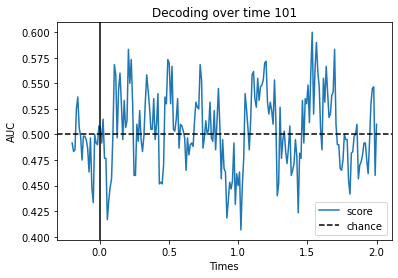

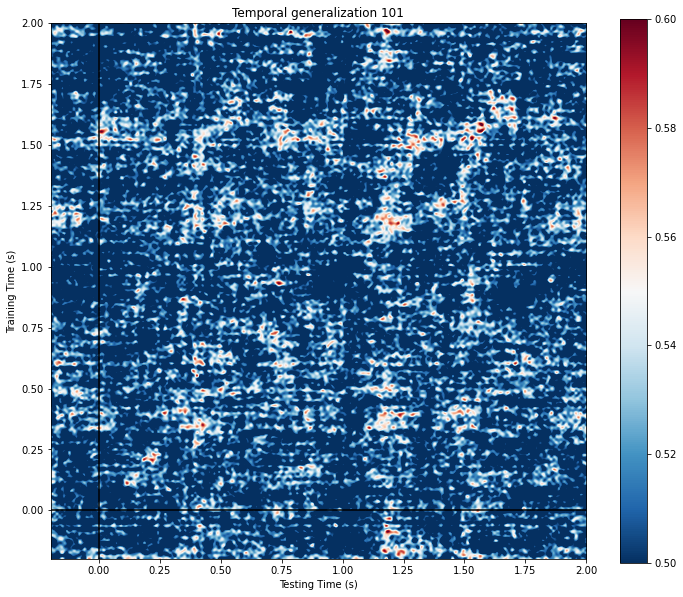

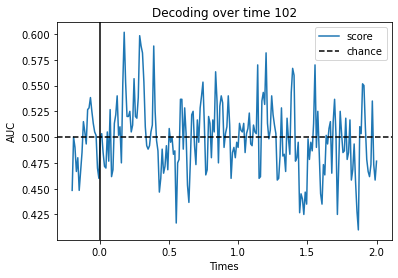

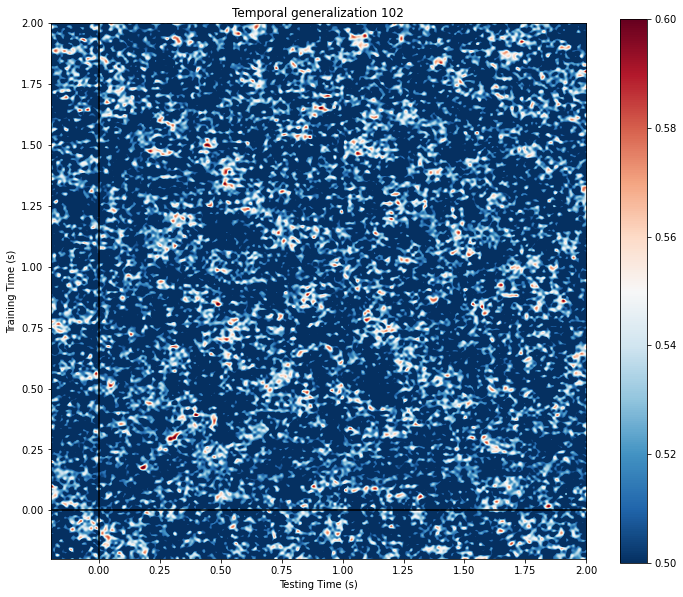

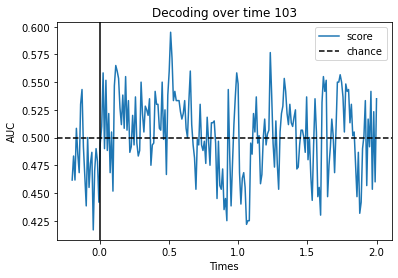

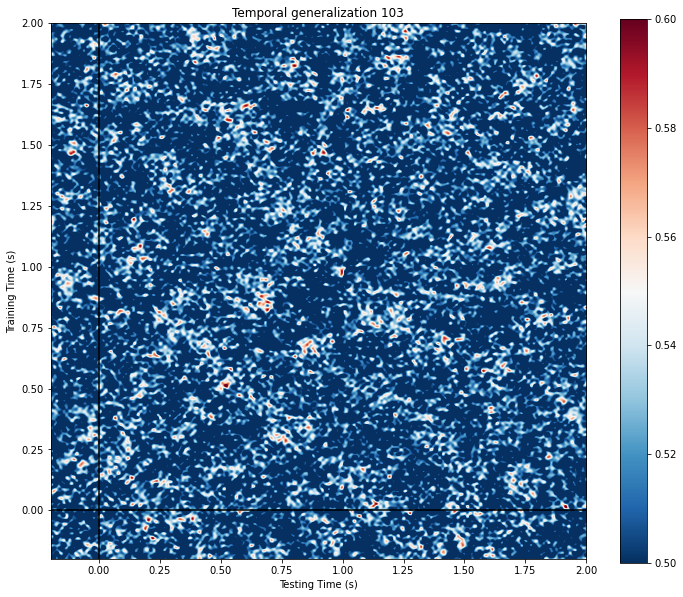

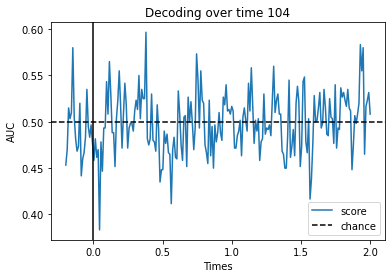

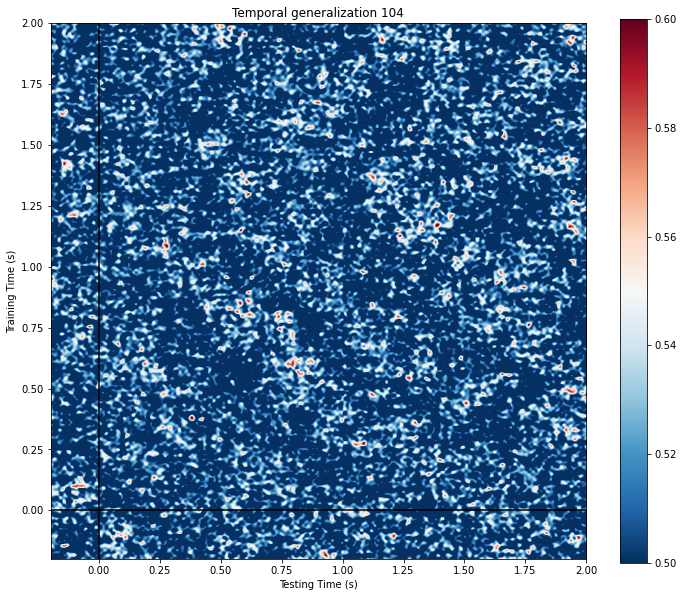

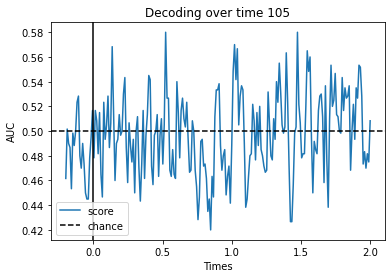

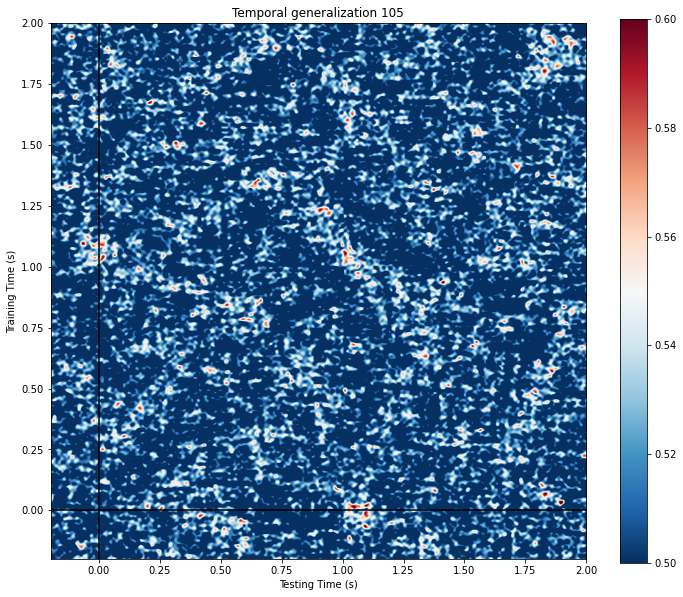

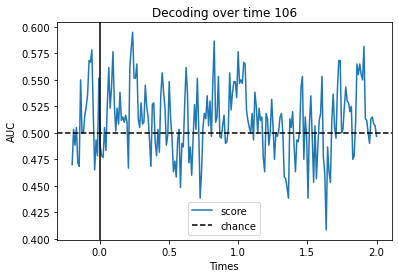

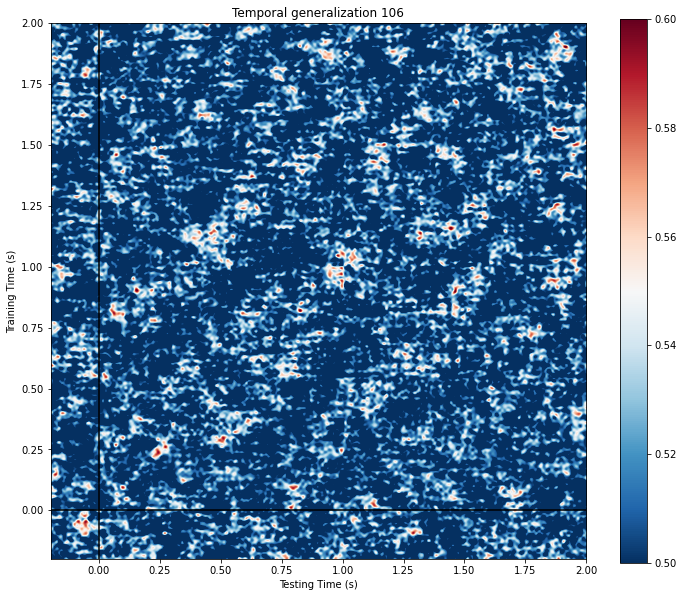

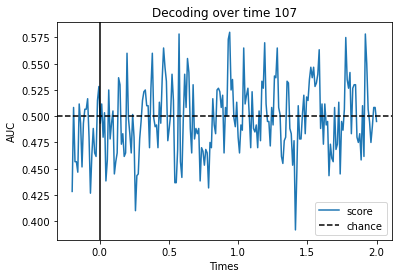

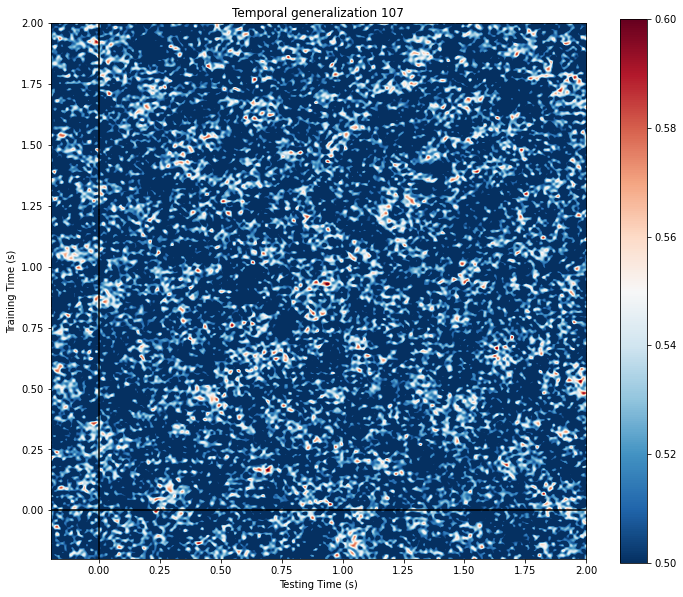

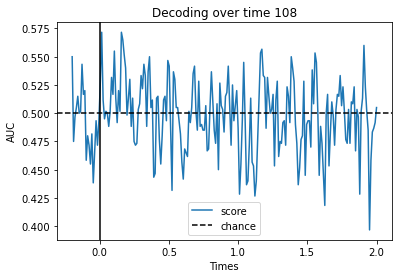

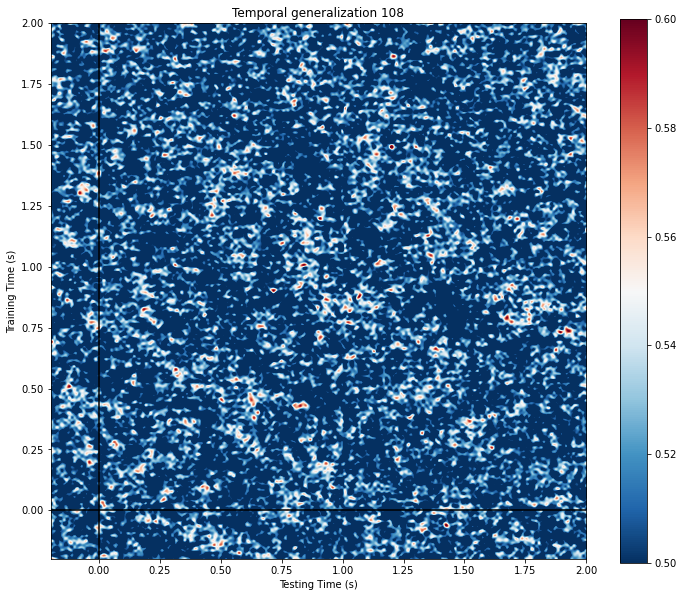

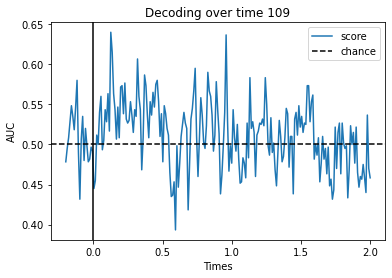

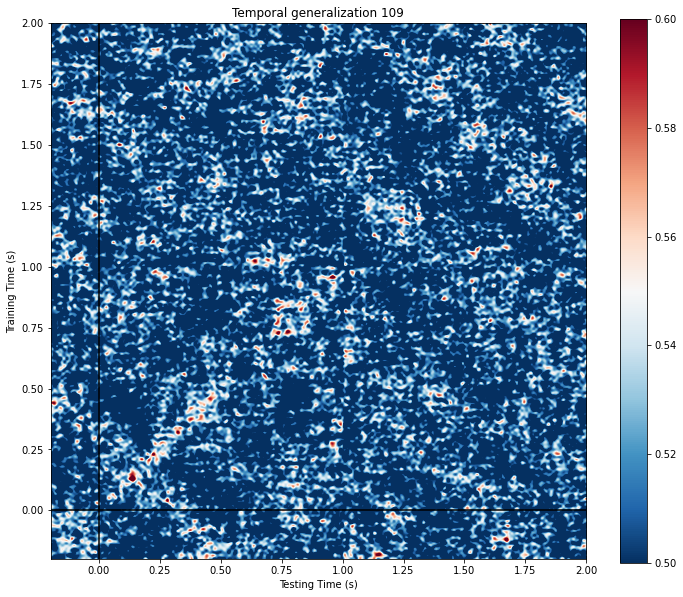

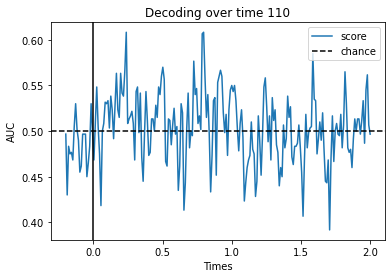

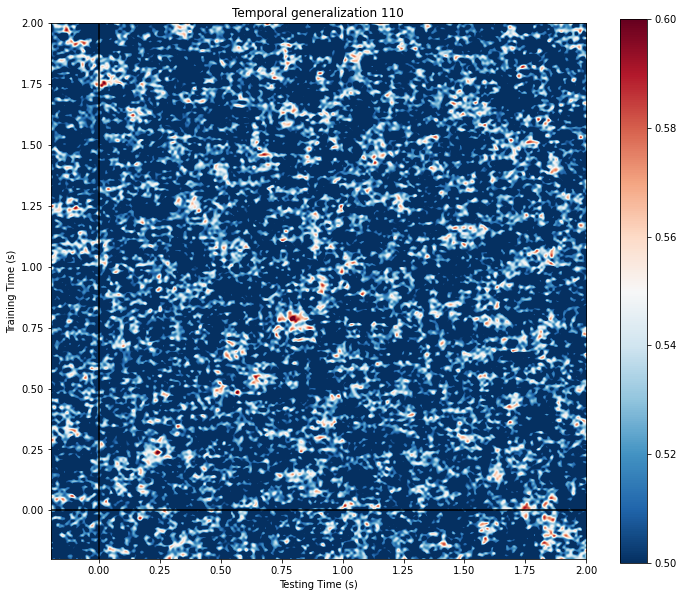

In [2]:
# eegData, behavData, channels = get_eeg_behav_data('102')
clf = make_pipeline(StandardScaler(),LinearSVC(C=1.0, max_iter = 10000));
time_gen = GeneralizingEstimator(clf, n_jobs=1, scoring=None, verbose=True)

n_folds = 6
# n_comb = len(list(itertools.combinations(np.unique(y), 2)))

subjects = [str(s) for s in range(101,111)]

cond = 'ColorValue'

if cond == 'ColorValue' or cond == 'FaceValue':
    classes = [-50,-20,0,20,50]
elif cond == 'Value-2':
    classes == [0,1,2,3,4]
else:
    classes = [1,2,3,4,5]
    
n_class = len(classes)
allCombs = list(itertools.combinations(classes, 2))

n_sample = 150
n_chan   = 64
n_ts = 119
n_td = 100
# Xstim = np.full((n_sample*len(subjects),n_chan,n_ts))

for s,subj in enumerate(subjects):
    
    print (subj + ' started')
    savefolder = os.path.join('Results',subj,'Temporal Generalization')
    if  not os.path.isdir (savefolder):
        os.mkdir(savefolder)

    eegData, behavData, channels = get_eeg_behav_data(subj)
    jitterCorrectDataFile = os.path.join('Results',subj,'stimJitterCorrected50.npy')

    Xstim, y, timeCondstim = get_eeg_svm_input(eegData, behavData, cond, (-.199,1), 10, jitterCorrectDataFile)
    
    Xdot,  _,timeConddot  = get_eeg_svm_input(eegData, behavData, cond, (1,2), 10)
    
    # concatenate stimulus and dot segments
    X = np.concatenate((Xstim,Xdot[:,:,1:]),axis = 2)
    time = np.concatenate((timeCondstim,timeConddot[1:]))
    
    scores_bin = np.full((len(allCombs),n_folds,len(time),len(time)),np.nan)

    for i, label in enumerate(allCombs):
        Xin = X[np.logical_or(y==label[0], y==label[1]),:,:]
        yin = y[np.logical_or(y==label[0], y==label[1])]
        # define the Temporal generalization object
#         set_trace()
        scores_bin[i,:,:,:] = cross_val_multiscore(time_gen, Xin, yin, cv=n_folds, n_jobs=1)
    savefile = os.path.join(savefolder,'scores'+cond+'_binary.npy')
    np.save(savefile,scores_bin)
    
    
    # Mean scores across binary classses
    scoresMean = np.nanmean(scores_bin, axis=(0,1))
    # Plot the diagonal (it's exactly the same as the time-by-time decoding above)
    fig, ax = plt.subplots()
    ax.plot(time, np.diag(scoresMean), label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    ax.set_xlabel('Times')
    ax.set_ylabel('AUC')
    ax.legend()
    ax.axvline(.0, color='k', linestyle='-')
    ax.set_title('Decoding over time '+ subj)
    savefig = os.path.join(savefolder,'accpertime'+cond+'_binary.png')
    plt.savefig(savefig)

    
    fig, ax = plt.subplots(1, 1, figsize = (12,10))
    im = ax.imshow(scoresMean, interpolation='lanczos', origin='lower', cmap='RdBu_r',
                   extent=time[[0, -1, 0, -1]], vmin=.5, vmax=.6) #, vmin=0., vmax=1.
    ax.set_xlabel('Testing Time (s)')
    ax.set_ylabel('Training Time (s)')
    ax.set_title('Temporal generalization '+ subj)
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')
    plt.colorbar(im, ax=ax)
    savefig = os.path.join(savefolder,'tempgen'+cond+'_binary.png')
    plt.savefig(savefig)

    print(subj+ ' done')